# Загрузка данных

Загрузим две таблицы: data (хранит данные по трем каналам измерений) и target_train (хранит классификацию для части объектов по месту дефекта ID/OD).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('data.csv', index_col=0)
target = pd.read_csv('target_train.csv')


In [2]:
data.head()

,id,time,ch0,ch1,ch2
0,1_1,0,372.271894,350.219643,408.527289
1,1_1,1,373.393195,349.845876,411.143658
2,1_1,2,371.898127,350.219643,412.638726
3,1_1,3,371.898127,350.967177,413.386260
4,1_1,4,371.898127,351.340944,414.133794


In [3]:
target.head()

,id,target
0,111_1,OD
1,103_1,OD
2,34_2,ID
3,78_1,OD
4,71_2,OD


Таким образом, таблица data показывает результаты трех измерений в последовательные моменты времени для разных id (труб). Эти данные по сути представляют собой временные ряды, то есть данные можно сгруппировать таким образом: id(идентификатор трубы), time(все моменты времени, в которые делались измерения), ch0/ch1/ch2 - три массива измерений, то есть получится 3 временных ряда с общим временем.
Таблица target по сути представляет классификацию на основе данных трех временных рядов из таблицы data, классифицируя id по двум группам: OD и ID (место деффекта).

# 1. EDA анализ

Перед группировкой рассмотрим сначала некоторые описательные статистики значений колонок, чтобы лучше ознакомиться со структурой данных и их особенностями.

In [4]:
from tabulate import tabulate

# Информация о таблице data
columns_to_analyze = ['time', 'ch0', 'ch1', 'ch2']
data_info = {
    'Column': columns_to_analyze,
    'Non-Null Count': data[columns_to_analyze].count(),
    'Dtype': data[columns_to_analyze].dtypes,
    'Range': [f'{data[col].min():.2f} - {data[col].max():.2f}' for col in columns_to_analyze],
    'Mean': data[columns_to_analyze].mean().round(2),
    'Std': data[columns_to_analyze].std().round(2)
}
data_info_df = pd.DataFrame(data_info)
print("Information about 'data' table:")
print(tabulate(data_info_df, headers='keys', tablefmt='pretty', showindex=False))
print(f"\nShape : {data.shape}")


# Информация о таблице target
target_info = {
    'Column': ['target'],
    'Non-Null Count': target['target'].count(),
    'Dtype': [target['target'].dtype]
}
target_info_df = pd.DataFrame(target_info)
print("\nInformation about 'target' table:")
print(tabulate(target_info_df, headers='keys', tablefmt='pretty', showindex=False))
print(f"\nShape : {target.shape}")

# Распределение классов
class_distribution = target['target'].value_counts()
class_dist_df = pd.DataFrame({
    'Class': class_distribution.index,
    'Count': class_distribution.values,
    'Percentage': (class_distribution.values / len(target) * 100).round(2)
})
print("\nClass Distribution:")
print(tabulate(class_dist_df, headers='keys', tablefmt='pretty', showindex=False))

Information about 'data' table:
+--------+----------------+---------+--------------------+--------+--------+
| Column | Non-Null Count |  Dtype  |       Range        |  Mean  |  Std   |
+--------+----------------+---------+--------------------+--------+--------+
|  time  |     588000     |  int64  |   0.00 - 2399.00   | 1199.5 | 692.82 |
|  ch0   |     588000     | float64 | -6801.81 - 4221.32 | 373.57 | 157.46 |
|  ch1   |     588000     | float64 | -6801.81 - 686.61  | 334.27 | 117.09 |
|  ch2   |     588000     | float64 | -263.13 - 4221.32  | 414.99 | 113.96 |
+--------+----------------+---------+--------------------+--------+--------+

Shape : (588000, 5)

Information about 'target' table:
+--------+----------------+--------+
| Column | Non-Null Count | Dtype  |
+--------+----------------+--------+
| target |      100       | object |
+--------+----------------+--------+

Shape : (100, 2)

Class Distribution:
+-------+-------+------------+
| Class | Count | Percentage |
+-------+-

Дополнительно проведем корреляционный анализ для определения взаимосвязей между числовыми переменными и вычислим корреляционную матрицу, которая покажет степень линейной связи между парами переменных. 

                id          time       ch0       ch1       ch2
id    1.000000e+00  5.651617e-16  0.001864 -0.025746  0.028180
time  5.651617e-16  1.000000e+00 -0.003228  0.004427 -0.010719
ch0   1.864210e-03 -3.228066e-03  1.000000  0.716825  0.704168
ch1  -2.574643e-02  4.427131e-03  0.716825  1.000000  0.097230
ch2   2.817951e-02 -1.071886e-02  0.704168  0.097230  1.000000


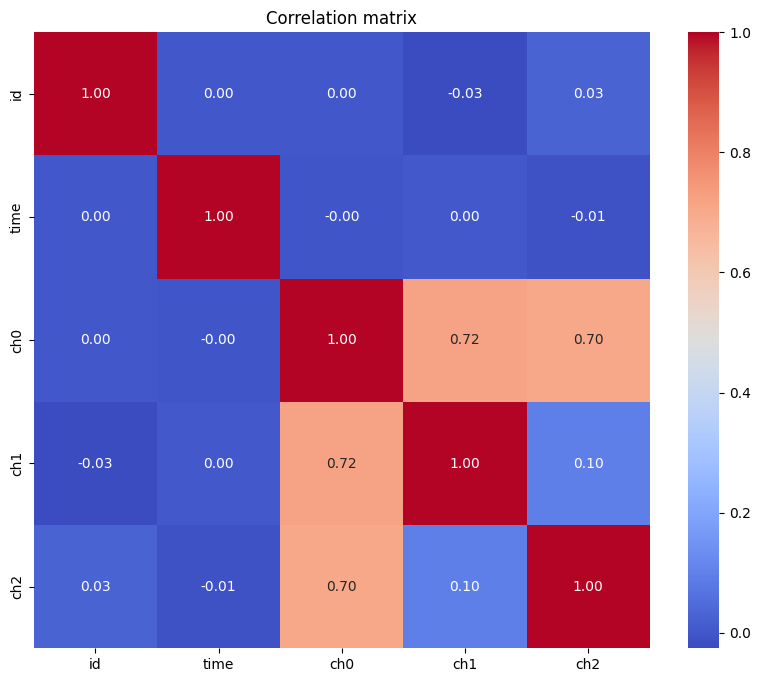

In [5]:
corr_matrix = data.corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation matrix')
plt.show()


Коэффициент > 0.7 говорит о том, что между переменными ch0 и ch1, сh0 и сh2 существует достаточно выраженная положительная связь.

Теперь провизуализируем несколько объектов из data. Посмотрим, как три измерения изменяются со временем.

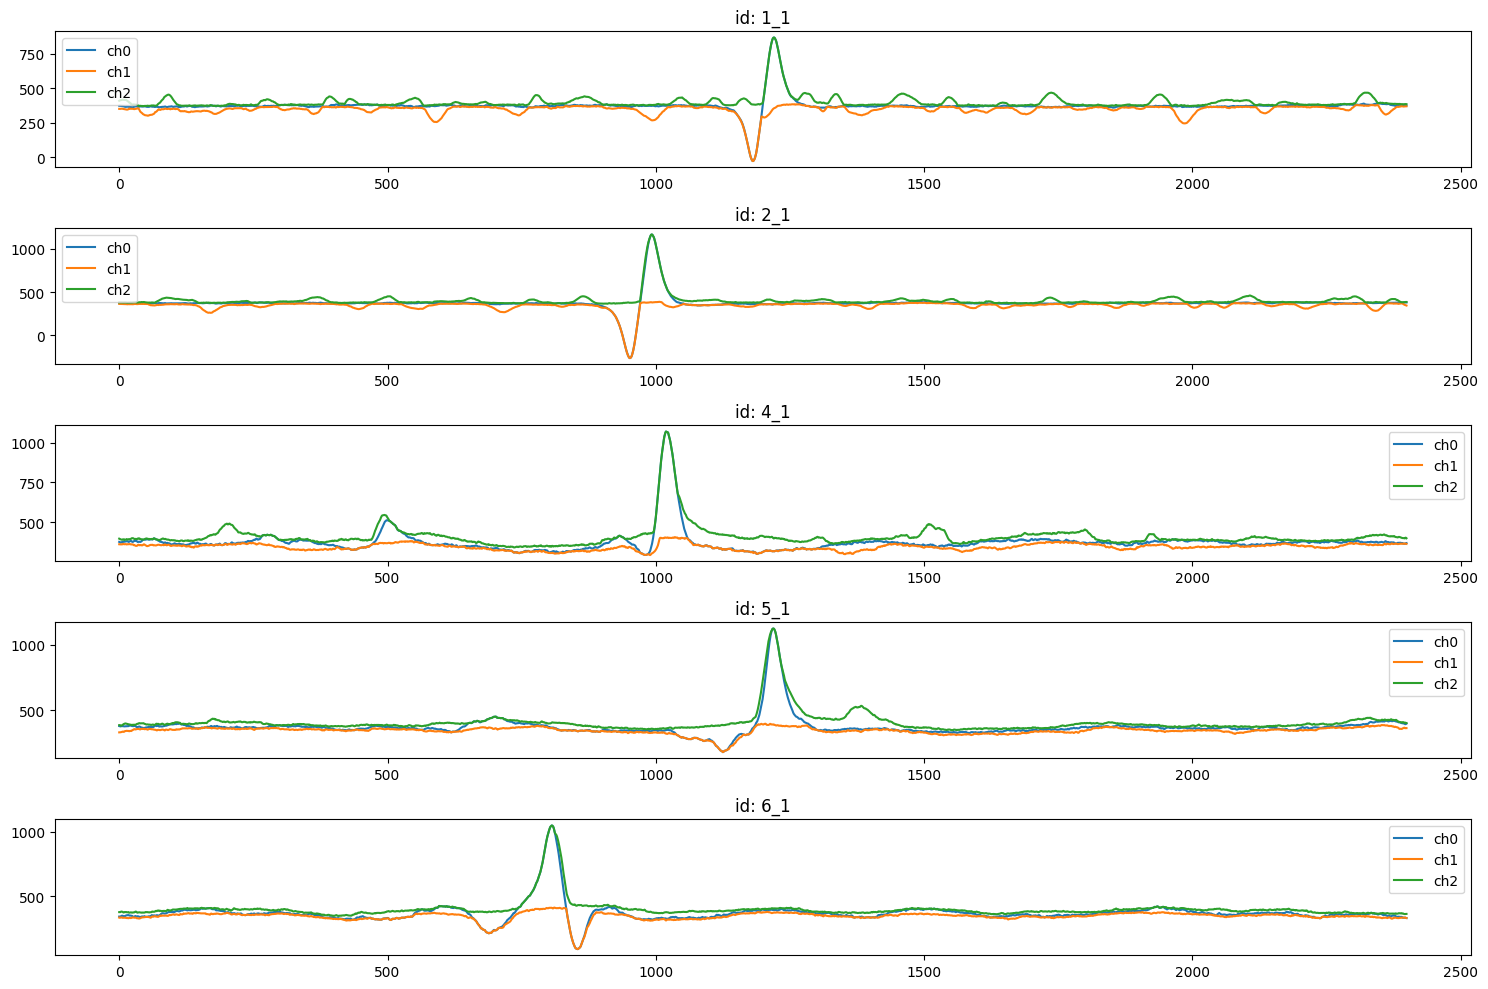

In [6]:
# Выберем несколько id для визуализации
sample_ids = data['id'].unique()[:5]

plt.figure(figsize=(15, 10))
for i, id in enumerate(sample_ids, 1):
    plt.subplot(5, 1, i)
    subset = data[data['id'] == id]
    plt.plot(subset['time'], subset['ch0'], label='ch0')
    plt.plot(subset['time'], subset['ch1'], label='ch1')
    plt.plot(subset['time'], subset['ch2'], label='ch2')
    plt.title(f'id: {id}')
    plt.legend()
plt.tight_layout()
plt.show()


По рисункам можно заметить, что ch0 периодически похож на ch1 и ch2, что соответвует ранее выявленной корреляции.

Теперь сгруппируем данные из data, чтобы получить удобный формат работы с временными рядами, а так же добавим данные c классификацией, чтобы в итоге таблица была выстроена по следующей логике: сначала идет id, затем данные по трем временным рядам с общим временем (в классическом представлении аналог date, values, только values несколько), а в конце класс для рассматриваемого id.

In [7]:
# Группируем данные по id
grouped = data.groupby('id')

# Группируем данные в новую таблицу
result = pd.DataFrame({
    'id': grouped.groups.keys(),
    'time': grouped['time'].apply(list),
    'ch0': grouped['ch0'].apply(list),
    'ch1': grouped['ch1'].apply(list),
    'ch2': grouped['ch2'].apply(list)
}).reset_index(drop=True)

# Добавление target
result = result.merge(target, on='id', how='left')
result.head()

,id,time,ch0,ch1,ch2,target
0,100_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[376.0095635993068, 377.50463144662024, 376.00...","[338.6328674164732, 340.87546918744323, 342.74...","[438.4286462246391, 435.4385105300124, 431.700...",NaN
1,100_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[339.3804013401298, 346.48197361486825, 354.33...","[293.7808319970727, 296.02343376804276, 300.50...","[392.08154295792536, 392.829076881582, 392.081...",NaN
2,101_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[394.6979116907237, 392.4553099197537, 391.334...","[366.6653895535984, 365.54408866811343, 365.17...","[420.487832056879, 415.6288615531106, 410.7698...",NaN
3,101_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[370.4030591718818, 372.2718939810235, 374.514...","[334.89519779818977, 334.89519779818977, 336.0...","[386.47503853050034, 386.47503853050034, 386.4...",NaN
4,102_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[361.43265208800176, 361.0588851261734, 359.93...","[354.7048467750917, 352.08847804229333, 351.71...","[383.11113587404526, 382.73736891221694, 382.3...",NaN


Можно заметить, что в колонке target есть NaN значения, что означает, что в таблице с классификацией присутвуют не все id, которые есть в таблице data.

Визуализируем несколько объектов из полученной таблицы, чтобы оценить, присутствуют ли визуальные особенности у временных рядов разных классов.

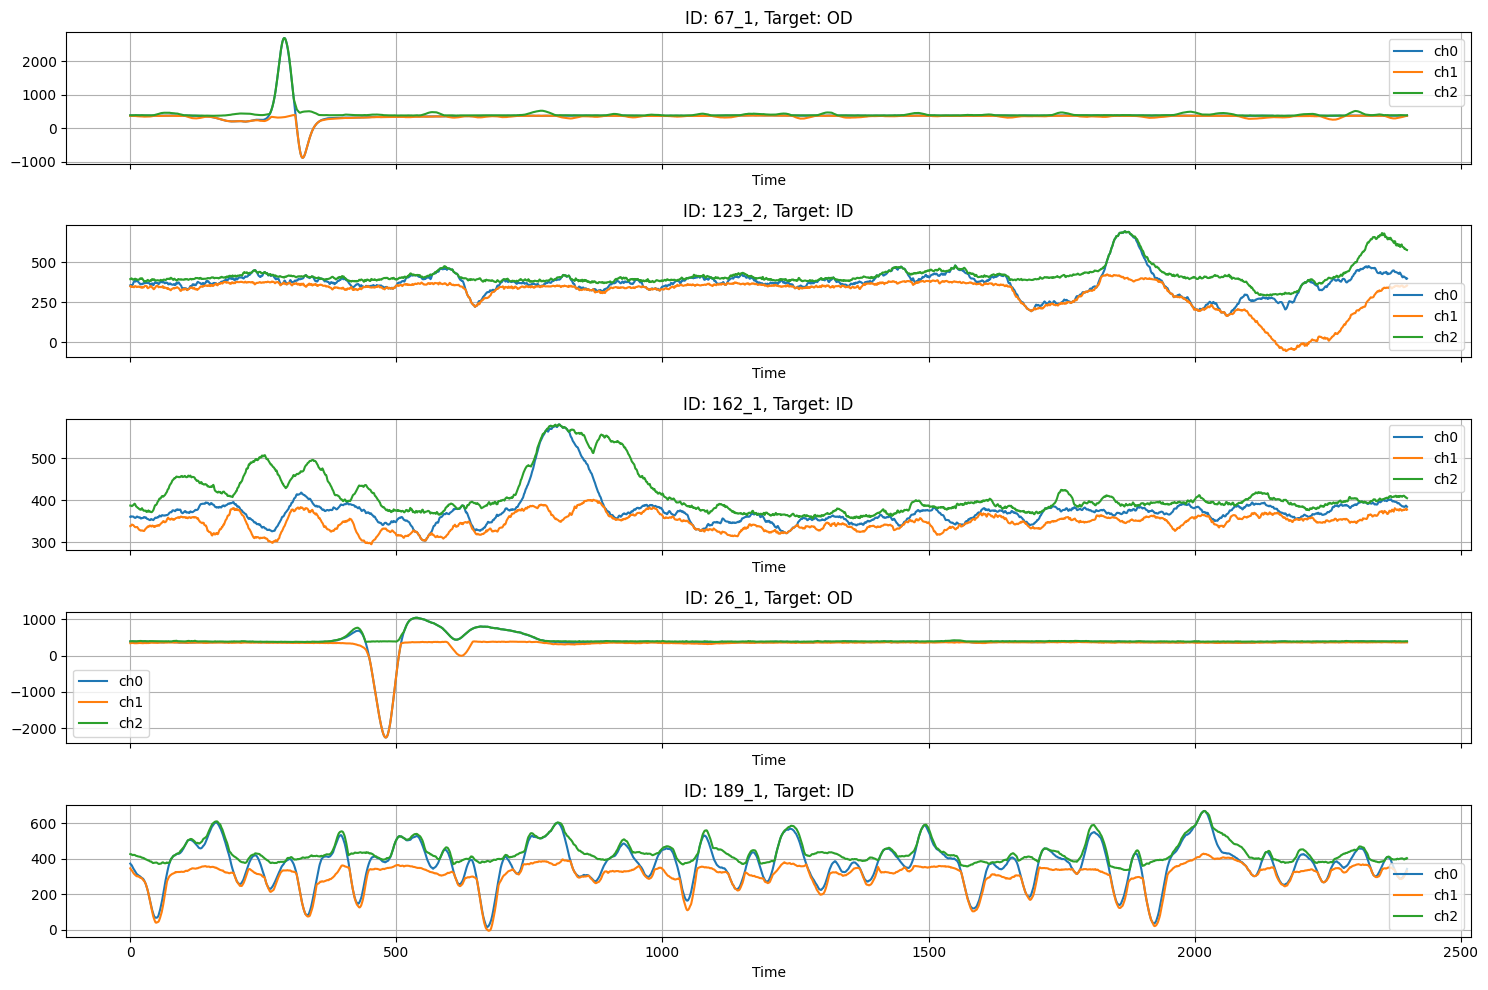

In [8]:
import matplotlib.pyplot as plt

df = result.copy()

# Выберем 5 случайных id для визуализации
df = df.dropna(subset=['target']).sample(n=5)

# Визуализация
n_plots = df.shape[0]
fig, axes = plt.subplots(n_plots, 1, figsize=(15, 10), sharex=True)

if n_plots == 1:
    axes = [axes]

for ax, (idx, row) in zip(axes, df.iterrows()):
    time = np.array(row['time'])
    ch0 = np.array(row['ch0'])
    ch1 = np.array(row['ch1'])
    ch2 = np.array(row['ch2'])
    target = row['target']
    
    ax.plot(time, ch0, label='ch0')
    ax.plot(time, ch1, label='ch1')
    ax.plot(time, ch2, label='ch2')
    ax.set_title(f'ID: {row["id"]}, Target: {target}')
    ax.legend()
    ax.set_xlabel('Time') 
    ax.grid(True)


plt.tight_layout()
plt.show()



Если несколько раз позапускать код выше, то можно заметить, что классу ID соответвуют графики с более нестабильными значениями измерений, которые сильно колеблются, у OD же обычно присутствует один выделяющийся скачок, а остальная часть графиков сравнительно стабильна.

При работе с временными рядами обычно выделяются различные фичи, основанные на характеристиках временных рядов, способные отразить особенности поведения временного ряда. Например, базовые статистические параметры, такие как сумма, медиана, среднее, стандартное отклонение, дисперсия, максимум и минимум, что позволяет получить общее понимание о распределении значений. Дополнительно рассчитываются изменения между последовательными значениями для выявления внутренней динамики ряда. Лаговые признаки и признаки, основанные на скользящих окнах, отражают зависимости и локальные тенденции, в то время как наклон линейной регрессии указывает на общий тренд данных. Сезонность выявляет повторяющиеся паттерны, а анализ выбросов, основанный на интерквартильном размахе, отражает степень аномальности данных. 

In [9]:
# Сезонность
def seasonal_variance(x):
    if len(x) > 12:
        truncated_x = x[:len(x) // 12 * 12]
        reshaped = [truncated_x[i::12] for i in range(12)]
        return np.var(reshaped)
    else:
        return np.nan

# Расчет количества выбросов на основе интерквартильного размаха
def count_outliers(x):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return np.sum((x < lower_bound) | (x > upper_bound))

def generating_features(df):
    features = pd.DataFrame()
    
    # Базовые статистические параметры
    features['id'] = df['id']
    for ch in ['ch0', 'ch1', 'ch2']:
        features[f'sum_{ch}'] = df[ch].apply(np.sum)
        features[f'median_{ch}'] = df[ch].apply(np.median)
        features[f'mean_{ch}'] = df[ch].apply(np.mean)
        features[f'length_{ch}'] = df[ch].apply(len)
        features[f'standard_deviation_{ch}'] = df[ch].apply(np.std)
        features[f'variance_{ch}'] = df[ch].apply(np.var)
        features[f'maximum_{ch}'] = df[ch].apply(np.max)
        features[f'minimum_{ch}'] = df[ch].apply(np.min)

        # Фичи, основанные на различиях
        features[f'mean_diff_{ch}'] = df[ch].apply(lambda x: np.mean(np.diff(x)) if len(x) > 1 else 0)
        features[f'std_diff_{ch}'] = df[ch].apply(lambda x: np.std(np.diff(x)) if len(x) > 1 else 0)
        features[f'max_diff_{ch}'] = df[ch].apply(lambda x: np.max(np.diff(x)) if len(x) > 1 else 0)
        features[f'min_diff_{ch}'] = df[ch].apply(lambda x: np.min(np.diff(x)) if len(x) > 1 else 0)
        features[f'sum_diff_{ch}'] = df[ch].apply(lambda x: np.sum(np.diff(x)) if len(x) > 1 else 0)

        # Лаговые фичи
        for lag in range(1, 4):
            features[f'lag_{lag}_{ch}'] = df[ch].apply(lambda x: x[-lag] if len(x) > lag else np.nan)

        # Скользящие окна
        features[f'rolling_mean_3_{ch}'] = df[ch].apply(lambda x: pd.Series(x).rolling(window=3).mean().iloc[-1] if len(x) >= 3 else np.nan)
        features[f'rolling_std_3_{ch}'] = df[ch].apply(lambda x: pd.Series(x).rolling(window=3).std().iloc[-1] if len(x) >= 3 else np.nan)

        # Тренд (снижение тренда линейной регрессии)
        features[f'trend_{ch}'] = df[ch].apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) > 1 else 0)

        # Сезонность
        features[f'seasonal_var_{ch}'] = df[ch].apply(seasonal_variance)

        # Выбросы
        features[f'outliers_count_{ch}'] = df[ch].apply(lambda x: count_outliers(x))

    # Фичи на основе временных интервалов
    features['start_time'] = df['time'].apply(lambda x: x[0])
    features['end_time'] = df['time'].apply(lambda x: x[-1])

    return features

res = generating_features(result)
res['target'] = result['target']
print(res.head())


      id        sum_ch0  median_ch0    mean_ch0  length_ch0  \
0  100_1  894750.638213  362.927720  372.812766        2400   
1  100_2  905750.599899  376.757098  377.396083        2400   
2  101_1  899543.078197  369.842409  374.809616        2400   
3  101_2  897640.978129  374.888263  374.017074        2400   
4  102_1  896547.335998  372.271894  373.561390        2400   

   standard_deviation_ch0  variance_ch0  maximum_ch0  minimum_ch0  \
0              104.316990  10882.034419  1286.879650   175.670472   
1              107.312721  11516.020091  1245.391517    89.330304   
2               43.667932   1906.888304   770.707475   279.203920   
3               42.519990   1807.949586   751.645360   247.807496   
4              116.621562  13600.588794  1476.005732  -195.106354   

   mean_diff_ch0  ...   lag_2_ch2   lag_3_ch2  rolling_mean_3_ch2  \
0      -0.000935  ...  455.621926  453.005558          455.497337   
1       0.022747  ...  433.195909  437.307345          434.940155   

Теперь попробуем посмотреть, насколько визуально разделимы стали данные со сгенерированными новыми фичами. Например, сделаем это на основе признаков, значения которых больше всего коррелируют с целевой переменной.

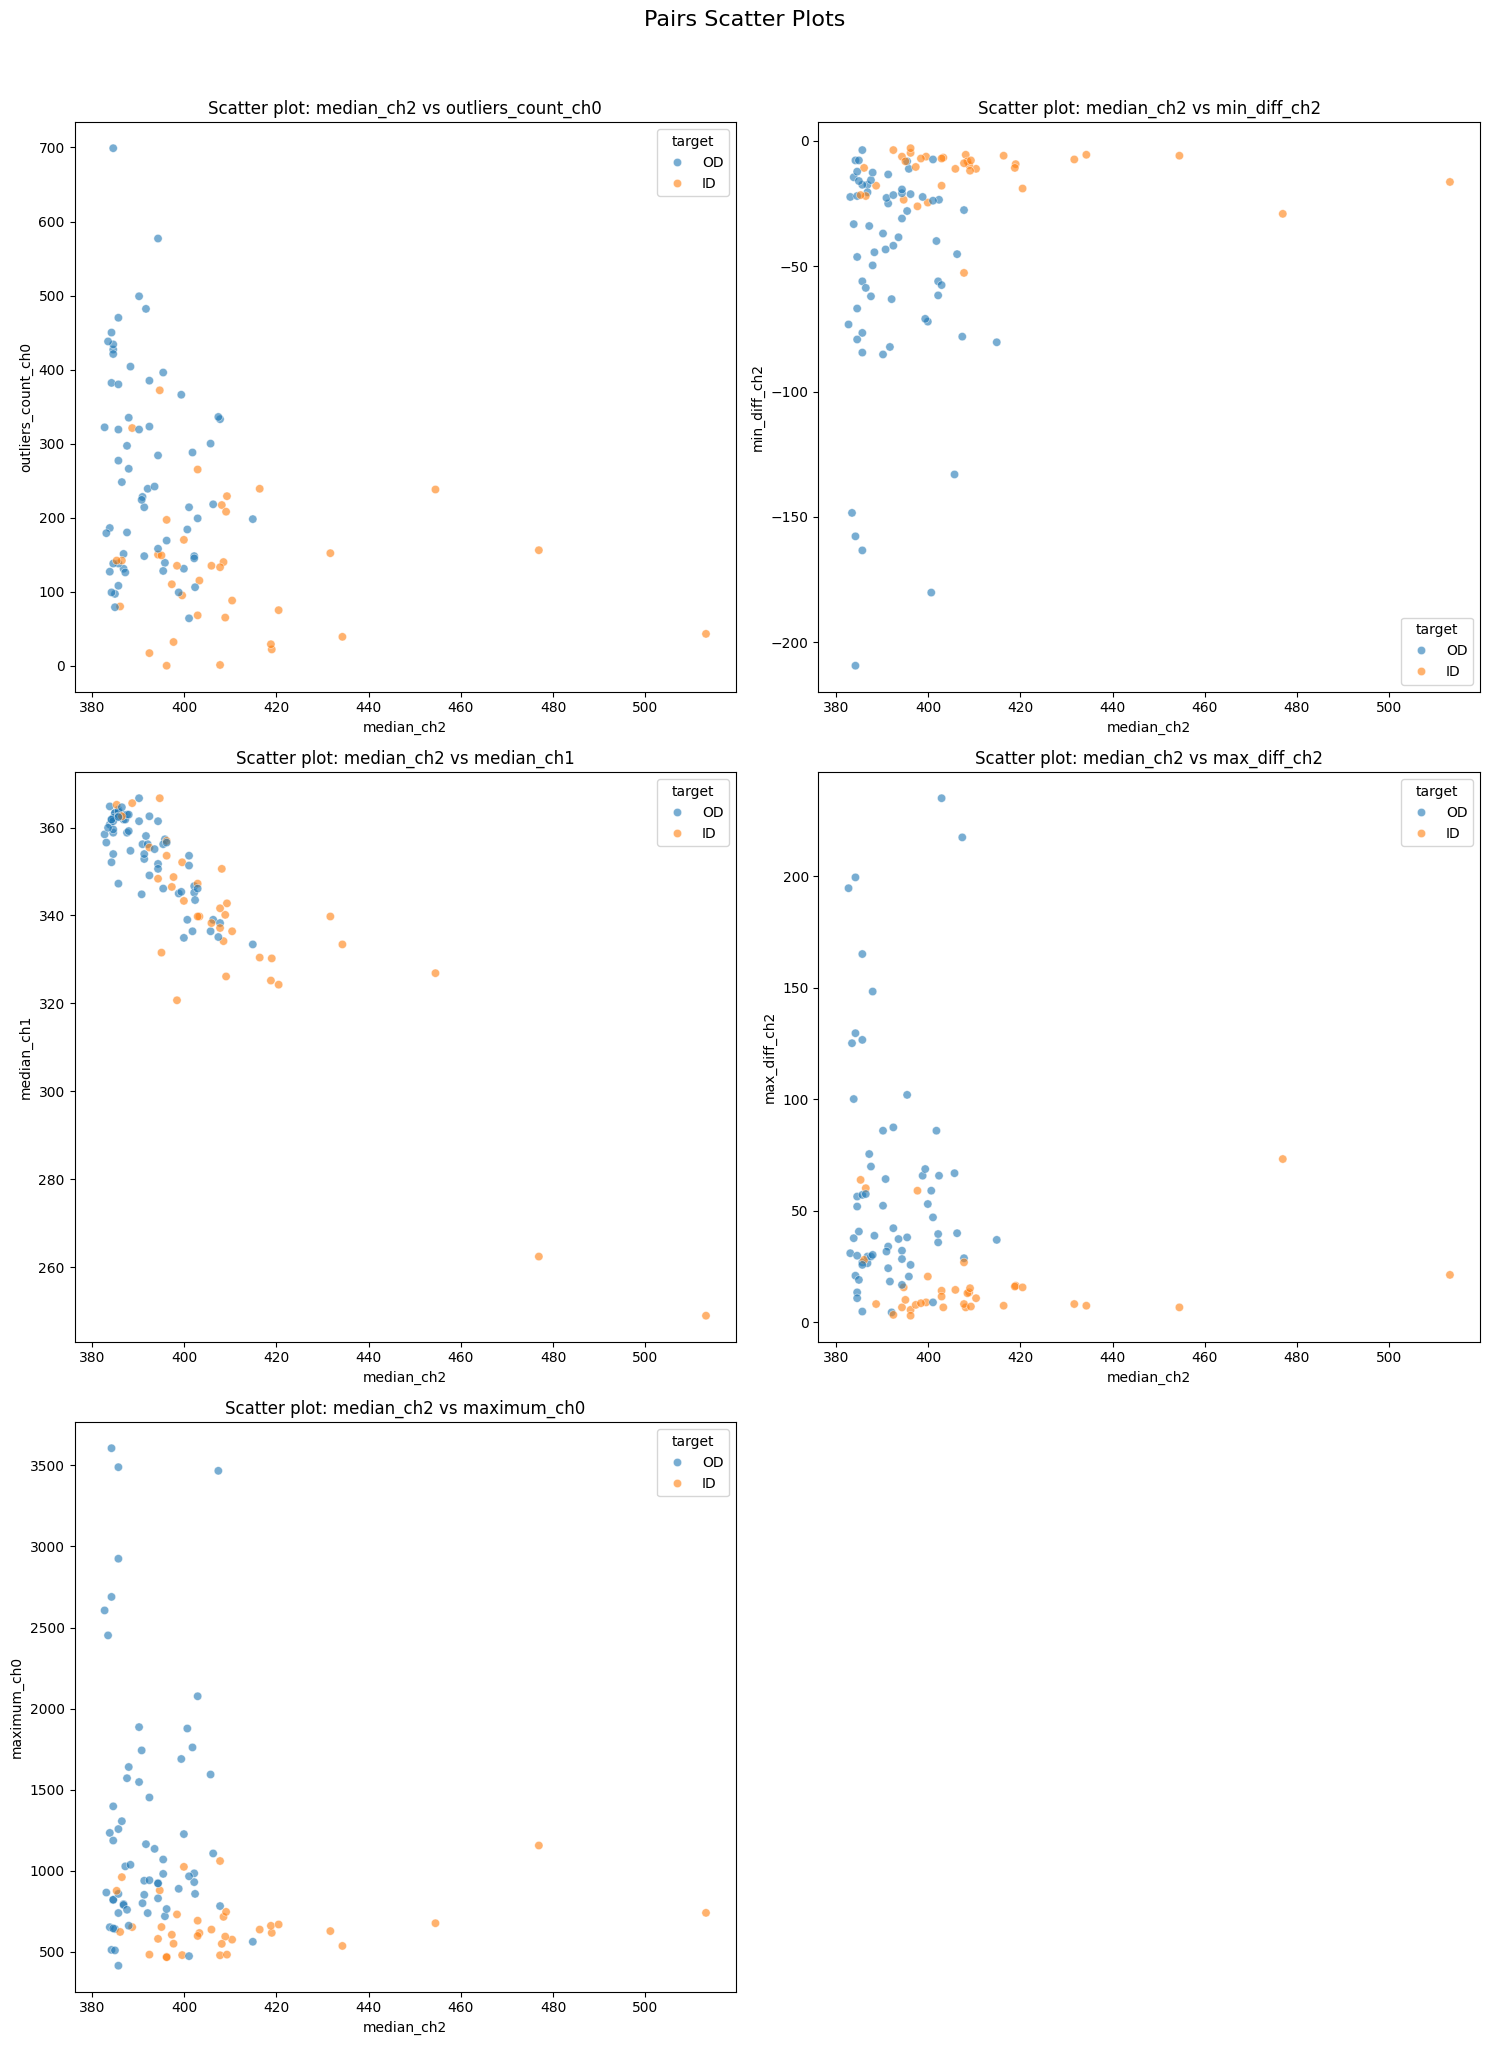

In [10]:
import warnings
from itertools import combinations

warnings.filterwarnings("ignore")

# Отфильтруем строки с NaN в target
df = res[res['target'].isin(['OD', 'ID'])].copy()

# Получим числовые колонки
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'id']

# Вычисляем корреляции
feature_importance = []
for col in numeric_cols:
    correlation = abs(df[col].corr((df['target'] == 'OD').astype(int)))
    feature_importance.append({
        'feature': col,
        'correlation': correlation
    })

# Получаем топ-10 фичей
top_features = pd.DataFrame(feature_importance).nlargest(10, 'correlation')['feature'].tolist()

# Делим по парам
feature_pairs = list(combinations(top_features, 2))[:5]

# Создаем сетку графиков
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.ravel()

# Строим графики для каждой пары
for idx, (feature1, feature2) in enumerate(feature_pairs):
    sns.scatterplot(data=df, x=feature1, y=feature2, hue='target', alpha=0.6, ax=axes[idx])
    axes[idx].set_title(f'Scatter plot: {feature1} vs {feature2}')
axes[-1].remove()


plt.suptitle('Pairs Scatter Plots', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Уже на полученных изображениях улавливается тенденция к разделению данных по представленным двум классам, визуально можно провести прямую между ними, которая разделит их с некоторой погрешностью.

**Вывод**:

Мы преобразовали исходные данные и сгенерировали новые фичи. Выяснилось, что: 

1. Данные по смыслу представляют собой временные ряды.

2. Между каналами измерений существует корреляция определенной структуры.

3. С точки зрения классификации данные разделимы.


# 2. Классификация

Разделим данные на обучающую и тестовую выборки.

In [11]:
train = res[res['target'].notna()]
test = res[res['target'].isna()]

print(train.shape, test.shape)

(100, 67) (145, 67)


Таким образом у нас есть 100 размеченных объектов и 145 неразмеченных, представляющих обучающую и тестовую выборки соответсвенно.

Чтобы хорошо классифицировать данные, из тестовой выборки нужно перебрать несколько моделей классификации и выбрать ту, которая покажет лучшее качество. Заданную метрику F1 будем проверять на кросс-валидации, а затем брать ее среднее для сравнения.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings("ignore")


# Подготовка данных
X = train.drop(['id', 'target'], axis=1)
y = train['target']

# Преобразование целевой переменной в числовой формат
le = LabelEncoder()
y = le.fit_transform(y)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Модели для перебора
models = [
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("SVM", SVC(random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Naive Bayes", GaussianNB()),
    ("XGBoost", XGBClassifier(random_state=42)),
    ("LightGBM", LGBMClassifier(random_state=42, verbosity=-1))
]

# Оценка F1 модели на кросс-валидации
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    return scores

# Результаты оценивания
results = []
print("Model Performance (F1-score):")
print("-----------------------------")
for name, model in models:
    scores = evaluate_model(model, X_scaled, y)
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append((name, mean_score, std_score))
    print(f"{name:<20}: {mean_score:.4f} (+/- {std_score:.4f})")
    print(f"  Fold scores: {', '.join([f'{score:.4f}' for score in scores])}")
    print()

# Определение лучшей модели
results.sort(key=lambda x: x[1], reverse=True)

best_model_name, best_score, _ = results[0]
print(f"\nBest model: {best_model_name} . Average F1-score: {best_score:.4f}")


Model Performance (F1-score):
-----------------------------
Random Forest       : 0.9003 (+/- 0.0305)
  Fold scores: 0.9231, 0.9231, 0.8696, 0.9286, 0.8571

Gradient Boosting   : 0.8757 (+/- 0.0672)
  Fold scores: 0.8800, 0.9167, 0.7619, 0.9630, 0.8571

SVM                 : 0.8415 (+/- 0.0650)
  Fold scores: 0.7333, 0.8462, 0.9167, 0.8966, 0.8148

K-Nearest Neighbors : 0.8445 (+/- 0.0439)
  Fold scores: 0.8276, 0.8000, 0.9286, 0.8387, 0.8276

Logistic Regression : 0.8903 (+/- 0.0505)
  Fold scores: 0.8148, 0.9231, 0.9600, 0.8966, 0.8571

Decision Tree       : 0.8681 (+/- 0.0645)
  Fold scores: 0.8889, 0.8696, 0.7619, 0.9630, 0.8571

Naive Bayes         : 0.6912 (+/- 0.1396)
  Fold scores: 0.4444, 0.8182, 0.6316, 0.7619, 0.8000

XGBoost             : 0.9043 (+/- 0.0575)
  Fold scores: 0.9231, 0.9600, 0.8182, 0.9630, 0.8571

LightGBM            : 0.9086 (+/- 0.0494)
  Fold scores: 0.8462, 0.9600, 0.9167, 0.9630, 0.8571


Best model: LightGBM . Average F1-score: 0.9086


Таким образом, лучшее качество показала модель LightGBM, ее и выберем для дальнейшего использования и улучшения.

Чтобы улучшить качество модели, нужно перебрать ее гиперпараметры(тюнинг), для этого используем сетку RandomizedSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
import warnings


warnings.filterwarnings("ignore")


# Подготовка данных
X = train.drop(['id', 'target'], axis=1)
y = train['target']

# Преобразование целевой переменной в числовой формат
le = LabelEncoder()
y = le.fit_transform(y)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Сетка гиперпараметров
param_distributions = {
    'num_leaves': randint(20, 3000),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(1, 300),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 2),
    'reg_lambda': uniform(0, 2),
}

# Выбранная модель с предыдущего шага
lgbm = LGBMClassifier(random_state=42, verbosity=-1)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Поиск лучших параметров
random_search.fit(X_scaled, y)

print("Best parameters:")
print(random_search.best_params_)

# Оценка F1 модели с лучшими гиперпараметрами на кросс-валидации
best_model = LGBMClassifier(**random_search.best_params_, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='f1')

print("\nCV results with best parameters:")
print(f"F1 scores: {', '.join([f'{score:.4f}' for score in cv_scores])}")
print(f"Mean F1 score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters:
{'colsample_bytree': 0.880387652583648, 'learning_rate': 0.03182890190925806, 'max_depth': 4, 'min_child_samples': 5, 'n_estimators': 128, 'num_leaves': 1465, 'reg_alpha': 1.973279157002351, 'reg_lambda': 0.7485415915122406, 'subsample': 0.7482568588267564}

CV results with best parameters:
F1 scores: 0.9630, 0.9600, 0.9600, 0.9630, 0.8571
Mean F1 score: 0.9406 (+/- 0.0418)


Осталось сделать предсказания на тестовых данных, перед этим надо не забыть обучить ранее выбранную модель с подобранными гиперпараметрами на всех обучающих данных.

In [14]:
# Подготовка тестовых данных
X_test = test.drop(['id', 'target'], axis=1)

# Масштабирование тестовых данных
X_test_scaled = scaler.transform(X_test)

# Инициализация модели с лучшими гиперпараметрами
best_model = LGBMClassifier(**random_search.best_params_, random_state=42, verbosity=-1)

# Обучение модели на всех тренировочных данных
best_model.fit(X_scaled, y)

# Предсказание на тестовых данных
y_pred = best_model.predict(X_test_scaled)

# Возврат числовых меток обратно в исходные категории
y_pred_labels = le.inverse_transform(y_pred)

# Таблица с результатами
results = pd.DataFrame({
    'id': test['id'],
    'target': y_pred_labels
})

# Сохранение результатов
output_path = 'predictions.csv'
results.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to predictions.csv


# 3. Кластеризация

Для кластеризации будем использовать все данные из таблицы, исключив target.

In [15]:
new = result.drop('target', axis=1)

In [16]:
new.head()

,id,time,ch0,ch1,ch2
0,100_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[376.0095635993068, 377.50463144662024, 376.00...","[338.6328674164732, 340.87546918744323, 342.74...","[438.4286462246391, 435.4385105300124, 431.700..."
1,100_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[339.3804013401298, 346.48197361486825, 354.33...","[293.7808319970727, 296.02343376804276, 300.50...","[392.08154295792536, 392.829076881582, 392.081..."
2,101_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[394.6979116907237, 392.4553099197537, 391.334...","[366.6653895535984, 365.54408866811343, 365.17...","[420.487832056879, 415.6288615531106, 410.7698..."
3,101_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[370.4030591718818, 372.2718939810235, 374.514...","[334.89519779818977, 334.89519779818977, 336.0...","[386.47503853050034, 386.47503853050034, 386.4..."
4,102_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[361.43265208800176, 361.0588851261734, 359.93...","[354.7048467750917, 352.08847804229333, 351.71...","[383.11113587404526, 382.73736891221694, 382.3..."


In [17]:
! pip install tslearn
! pip install kneed

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


В задаче кластеризации надо определить оптимальное число кластеров(подтипов дефектов) и затем кластеризовать данные.
Для этого сначала масштабируем данные с помощью TimeSeriesScalerMeanVariance для нормализации временных рядов, затем реализуем elbow method для определения оптимального количества кластеров, в цикле перебирается число кластеров от 1 до 10, для каждого значения выполняется кластеризация методом k-means с использованием метрики DTW (Dynamic Time Warping) для учета не только амплитуды, но и формы временных рядов при их сравнении. Для автоматического определения точки перегиба(локтя) используется алгоритм KneeLocator из библиотеки kneed(ожидается значение > 3, так как подтипы дефектов: коррозия, вмятина, выбоина и тд). Затем выполняется окончательная кластеризация временных рядов. 
Для визуализации результатов сначала выводятся графики типичных представителей каждого кластера (центроиды), а потом гистограмма распределения объектов по кластерам.

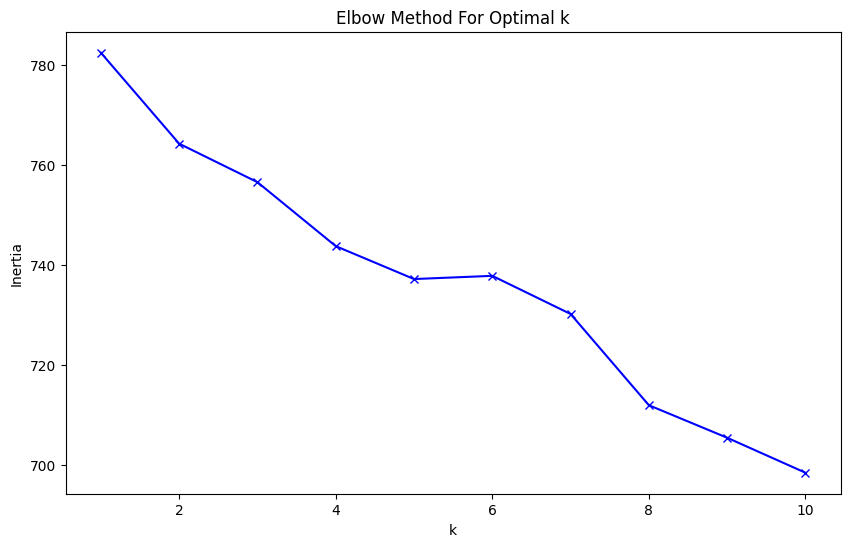

Optimal number of clusters: 4


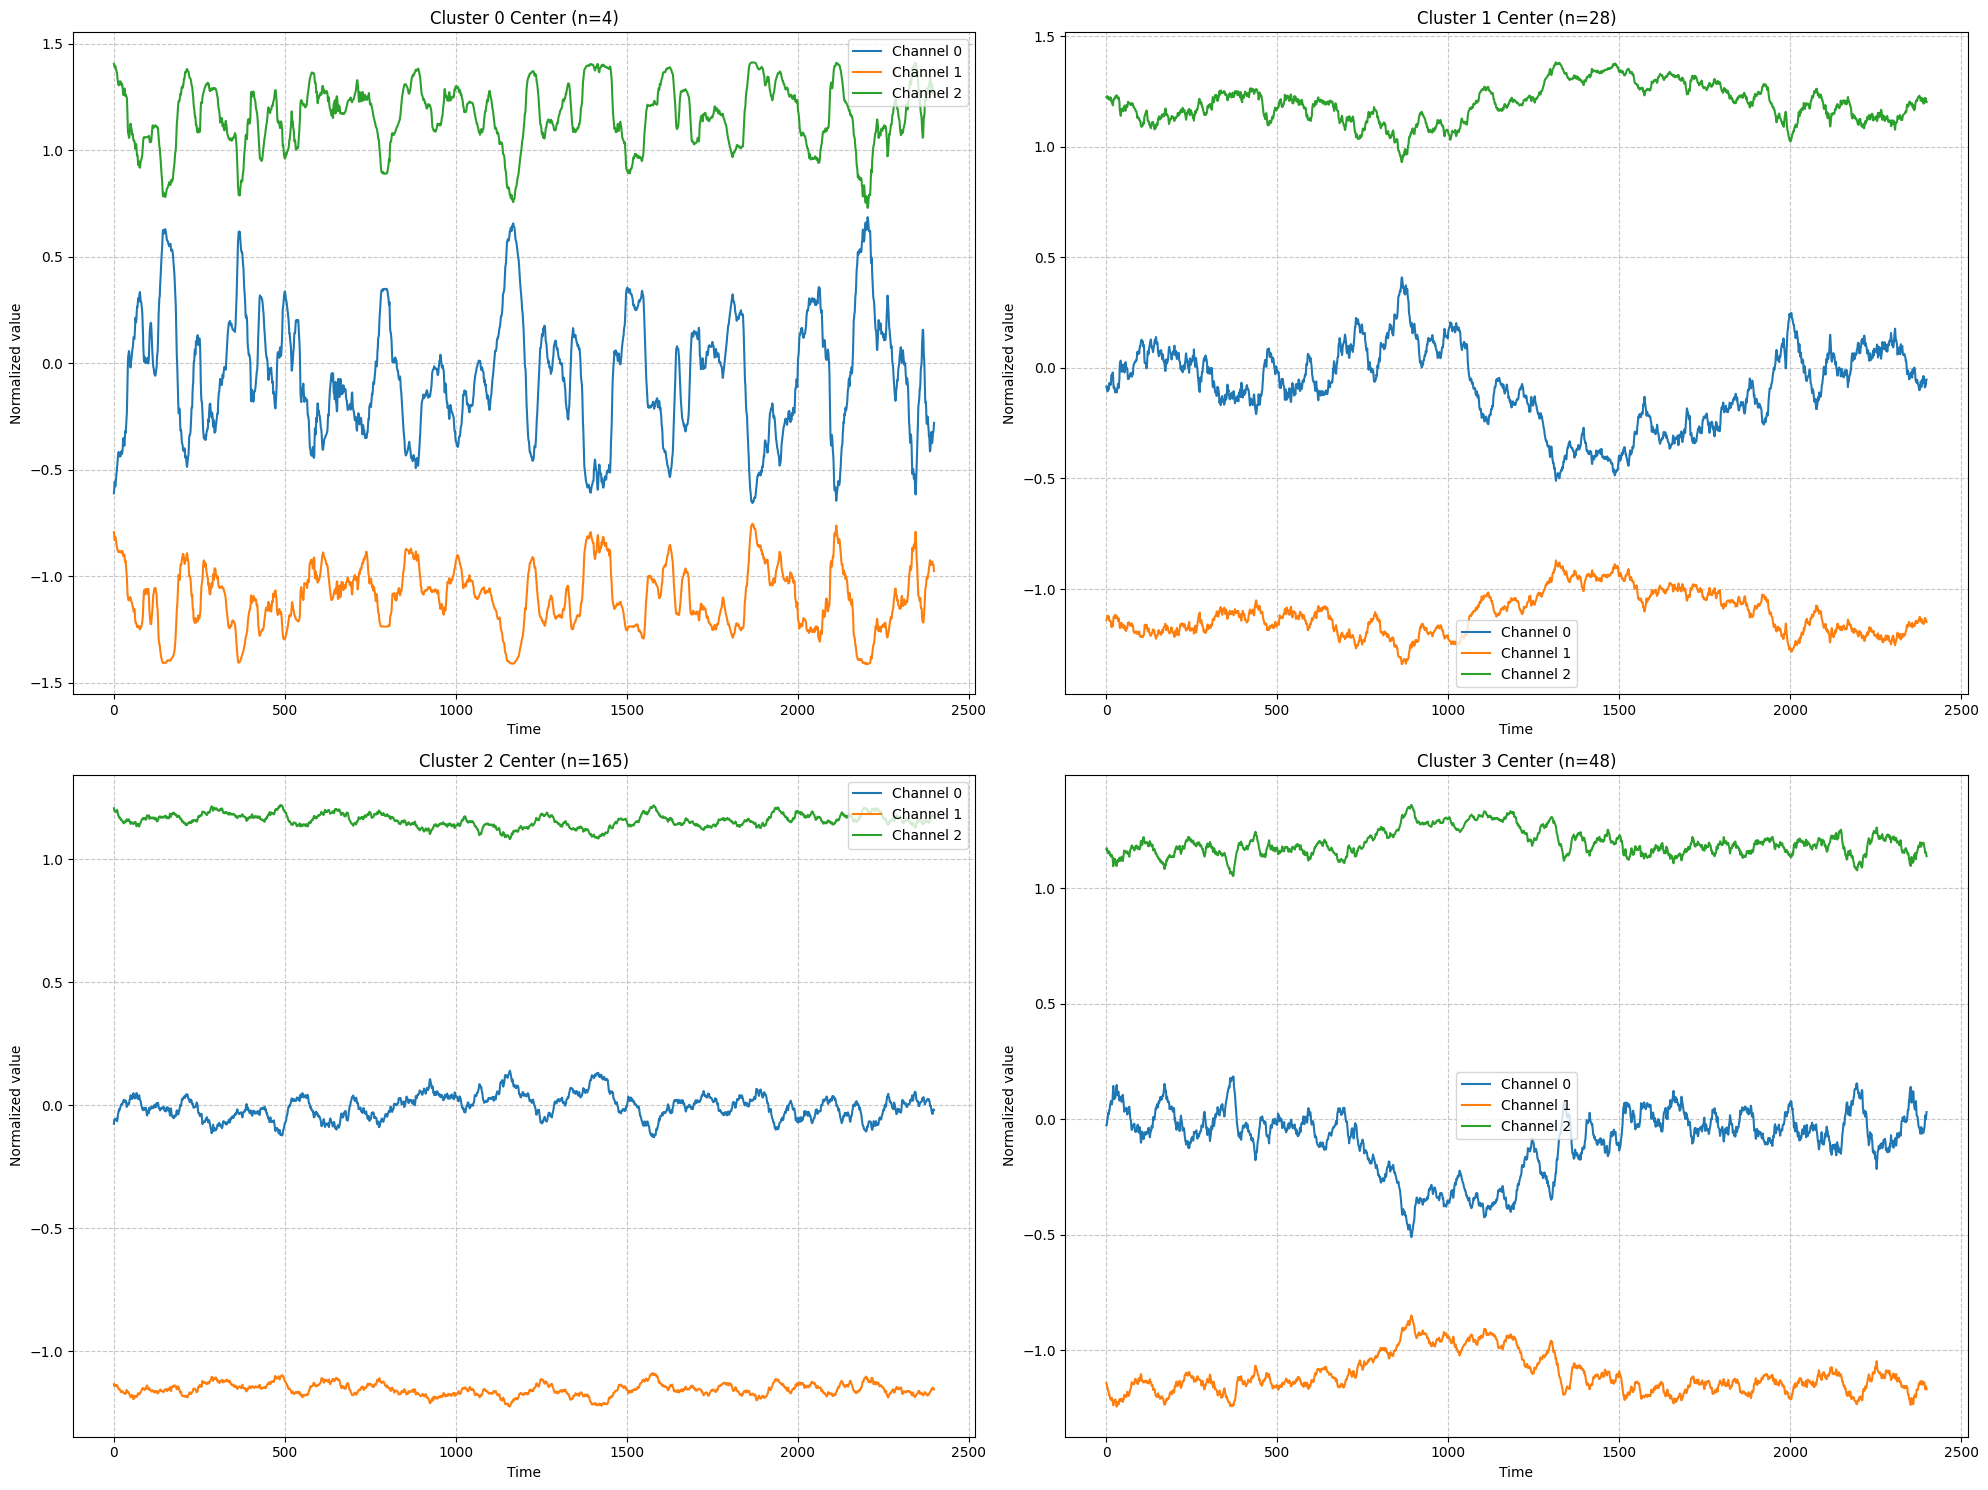

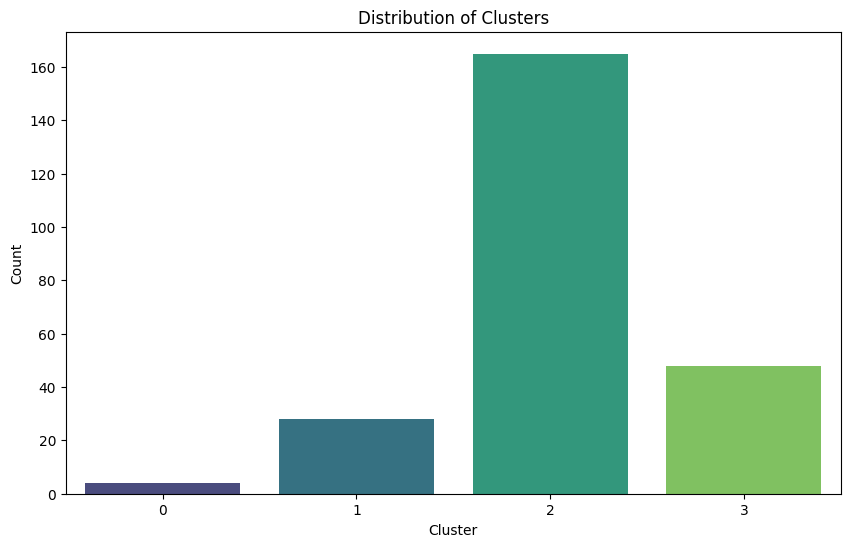

Clustered data saved to clustered_data.csv


In [18]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from kneed import KneeLocator

# Подготовка данных
data = new

grouped_data = data.groupby('id')

time_series = []
for id_, group in grouped_data:
    ts = np.array([group['ch0'].values[0], group['ch1'].values[0], group['ch2'].values[0]])
    time_series.append(ts)

time_series = np.array(time_series)
scaler = TimeSeriesScalerMeanVariance()
time_series_scaled = scaler.fit_transform(time_series)

# Определение оптимального числа кластеров
inertias = []
K = range(1, 11)

for k in K:
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
    kmeans.fit(time_series_scaled)
    inertias.append(kmeans.inertia_)

# Визуализация elbow method
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Автоматическое определение точки перегиба (локтя)
kneedle = KneeLocator(K, inertias, S=1.0, curve='convex', direction='decreasing')
n_clusters = kneedle.elbow

print(f"Optimal number of clusters: {n_clusters}")

# Кластеризация временных рядов на основе оптимального числа кластеров
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = kmeans.fit_predict(time_series_scaled)

clustered_data = pd.DataFrame({'id': grouped_data.groups.keys(), 'Cluster': labels})


# Отображение типичного представителя каждого кластера
plt.figure(figsize=(20, 15))
for cluster_idx in range(n_clusters):
    plt.subplot(2, (n_clusters + 1) // 2, cluster_idx + 1)
    cluster_center = kmeans.cluster_centers_[cluster_idx]
    for channel_idx in range(cluster_center.shape[0]):
        plt.plot(cluster_center[channel_idx], label=f'Channel {channel_idx}')
    plt.title(f"Cluster {cluster_idx} Center (n={np.sum(labels == cluster_idx)})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylabel("Normalized value")
    plt.xlabel("Time")

plt.tight_layout()
plt.show()

# Распределение кластеров
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=clustered_data, palette='viridis')
plt.title("Distribution of Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Сохранение
output_path = 'clustered_data.csv'
clustered_data.to_csv(output_path, index=False)
print(f"Clustered data saved to {output_path}")



Изучим полученные кластеры в контексте внутренних и внешних дефектов.

In [19]:
clustered_data = pd.read_csv('clustered_data.csv')
target_train = pd.read_csv('target_train.csv')

# Объединение таблиц по id
merged_df = pd.merge(target_train, clustered_data, on='id')

# Получение статистики для каждого кластера
cluster_stats = pd.crosstab(merged_df['Cluster'], merged_df['target'])

print("Cluster statistics:")
print(cluster_stats)


Cluster statistics:
target   ID  OD
Cluster        
0         1   0
1         4   5
2        29  46
3         2  13


Попытаемся интерпретировать полученные значения. В задании уже были приведены 3 подтипа дефектов труб: коррозия, вмятина и выбоина, но мы выделили 4 кластера. Пусть, например, 4 подтипом будет расслоение металла. По сути коррозия может быть как внутренней (ID), так и внешней (OD), вмятина обычно внешняя (OD), выбоина может быть как внутренней (ID), так и внешней (OD), а расслоение металла обычно внутреннее (ID). Тогда, возможно, кластер с номером 3 соответвует вмятине, кластер с номером 0 соответствует расслоению металла, кластер с номером 2 соответствует коррозии(так как она встречается в процентном соотношении чаще, чем выбоина), а кластер с номером 1 это выбоина.